### **Importing  the Librairies**

In [2]:
# Install nightly package for some functionalities that aren't in alpha
!pip install tf-nightly-gpu-2.0-preview

# Install TF Hub for TF2
!pip install 'tensorflow-hub == 0.4'


ERROR: Could not find a version that satisfies the requirement tf-nightly-gpu-2.0-preview
ERROR: No matching distribution found for tf-nightly-gpu-2.0-preview
ERROR: Invalid requirement: "'tensorflow-hub"


In [1]:
from __future__ import absolute_import, division, print_function, unicode_literals


import tensorflow as tf
#tf.logging.set_verbosity(tf.logging.ERROR)
#tf.enable_eager_execution()

import tensorflow_hub as hub
import os
from tensorflow.keras.layers import Dense, Flatten, Conv2D
from tensorflow.keras import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import layers
#from keras import optimizers




In [2]:
# verify TensorFlow version

print("Version: ", tf.__version__)
print("Eager mode: ", tf.executing_eagerly())
print("Hub version: ", hub.__version__)
print("GPU is", "available" if tf.test.is_gpu_available() else "NOT AVAILABLE")


Version:  2.4.1
Eager mode:  True
Hub version:  0.5.0
Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.
GPU is NOT AVAILABLE


### Load the data
We will download a public dataset of 54,305 images of diseased and healthy plant leaves collected under controlled conditions ( [PlantVillage Dataset](https://storage.googleapis.com/plantdata/PlantVillage.tar)). The images cover 14 species of crops, including: apple, blueberry, cherry, grape, orange, peach, pepper, potato, raspberry, soy, squash, strawberry and tomato. It contains images of 17 basic diseases, 4 bacterial diseases, 2 diseases caused by mold (oomycete), 2 viral diseases and 1 disease caused by a mite. 12 crop species also have healthy leaf images that are not visibly affected by disease. Then store the downloaded zip file to the "/tmp/" directory.

we'll  need to make sure the input data is resized to 224x224 or 229x229 pixels as required by the networks.



In [11]:
zip_file = 'C:/Users/Chavan/Desktop/Akhilesh_Deo/project/Plant Monitoring/module 2/Plant.zip'



### Prepare training and validation  dataset
Create the training and validation directories 

In [13]:
data_dir = r'C:\Users\Chavan\Desktop\Akhilesh_Deo\project\Plant Monitoring\module 2\Plant'
train_dir = r'C:\Users\Chavan\Desktop\Akhilesh_Deo\project\Plant Monitoring\module 2\output\train'
validation_dir = r'C:\Users\Chavan\Desktop\Akhilesh_Deo\project\Plant Monitoring\module 2\output\val'


In [14]:
import time
import os
from os.path import exists

def count(dir, counter=0):
    "returns number of files in dir and subdirs"
    for pack in os.walk(dir):
        for f in pack[2]:
            counter += 1
    return dir + " : " + str(counter) + "files"


In [15]:
print('total images for training :', count(train_dir))
print('total images for validation :', count(validation_dir))


total images for training : C:\Users\Chavan\Desktop\Akhilesh_Deo\project\Plant Monitoring\module 2\output\train : 42255files
total images for validation : C:\Users\Chavan\Desktop\Akhilesh_Deo\project\Plant Monitoring\module 2\output\val : 10583files


### Label mapping

You'll also need to load in a mapping from category label to category name. You can find this in the file `categories.json`. It's a JSON object which you can read in with the [`json` module](https://docs.python.org/2/library/json.html). This will give you a dictionary mapping the integer encoded categories to the actual names of the plants and diseases.

In [16]:
import json

with open(r'C:\Users\Chavan\Desktop\Akhilesh_Deo\project\Plant Monitoring\module 2\categories.json', 'r') as f:
    cat_to_name = json.load(f)
    classes = list(cat_to_name.values())
    
print (classes)

['Apple___Apple_scab', 'Apple___Black_rot', 'Apple___Cedar_apple_rust', 'Apple___healthy', 'Blueberry___healthy', 'Cherry_(including_sour)___Powdery_mildew', 'Cherry_(including_sour)___healthy', 'Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot', 'Corn_(maize)___Common_rust_', 'Corn_(maize)___Northern_Leaf_Blight', 'Corn_(maize)___healthy', 'Grape___Black_rot', 'Grape___Esca_(Black_Measles)', 'Grape___Leaf_blight_(Isariopsis_Leaf_Spot)', 'Grape___healthy', 'Orange___Haunglongbing_(Citrus_greening)', 'Peach___Bacterial_spot', 'Peach___healthy', 'Pepper,_bell___Bacterial_spot', 'Pepper,_bell___healthy', 'Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy', 'Raspberry___healthy', 'Soybean___healthy', 'Squash___Powdery_mildew', 'Strawberry___Leaf_scorch', 'Strawberry___healthy', 'Tomato___Bacterial_spot', 'Tomato___Early_blight', 'Tomato___Late_blight', 'Tomato___Leaf_Mold', 'Tomato___Septoria_leaf_spot', 'Tomato___Spider_mites Two-spotted_spider_mite', 'Tomato___Target_Sp

In [21]:
print('Number of classes:',len(classes))

Number of classes: 38


###Select the Hub/TF2 module to use

In [22]:
module_selection = ("inception_v3", 299, 2048) #@param ["(\"mobilenet_v2\", 224, 1280)", "(\"inception_v3\", 299, 2048)"] {type:"raw", allow-input: true}
handle_base, pixels, FV_SIZE = module_selection
MODULE_HANDLE ="https://tfhub.dev/google/tf2-preview/{}/feature_vector/2".format(handle_base)
IMAGE_SIZE = (pixels, pixels)
print("Using {} with input size {} and output dimension {}".format(
  MODULE_HANDLE, IMAGE_SIZE, FV_SIZE))

BATCH_SIZE = 64 #@param {type:"integer"}

Using https://tfhub.dev/google/tf2-preview/inception_v3/feature_vector/2 with input size (299, 299) and output dimension 2048


### Data Preprocessing

Let's set up data generators that will read pictures in our source folders, convert them to `float32` tensors, and feed them (with their labels) to our network. 

As you may already know, data that goes into neural networks should usually be normalized in some way to make it more amenable to processing by the network. (It is uncommon to feed raw pixels into a convnet.) In our case, we will preprocess our images by normalizing the pixel values to be in the `[0, 1]` range (originally all values are in the `[0, 255]` range).



In [23]:
# Inputs are suitably resized for the selected module. Dataset augmentation (i.e., random distortions of an image each time it is read) improves training, esp. when fine-tuning.

validation_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255)
validation_generator = validation_datagen.flow_from_directory(
    validation_dir, 
    shuffle=False, 
    seed=42,
    color_mode="rgb", 
    class_mode="categorical",
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE)

do_data_augmentation = True #@param {type:"boolean"}
if do_data_augmentation:
  train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
      rescale = 1./255,
      rotation_range=40,
      horizontal_flip=True,
      width_shift_range=0.2, 
      height_shift_range=0.2,
      shear_range=0.2, 
      zoom_range=0.2,
      fill_mode='nearest' )
else:
  train_datagen = validation_datagen
  
train_generator = train_datagen.flow_from_directory(
    train_dir, 
    subset="training", 
    shuffle=True, 
    seed=42,
    color_mode="rgb", 
    class_mode="categorical",
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE)


Found 10583 images belonging to 38 classes.
Found 42255 images belonging to 38 classes.


###Build the model
All it takes is to put a linear classifier on top of the feature_extractor_layer with the Hub module.

For speed, we start out with a non-trainable feature_extractor_layer, but you can also enable fine-tuning for greater accuracy.

In [24]:
import tensorflow.compat.v1.keras.backend as K
import tensorflow as tf
tf.compat.v1.disable_eager_execution()

feature_extractor = hub.KerasLayer(MODULE_HANDLE,
                                   input_shape=IMAGE_SIZE+(3,),
                                   output_shape=[FV_SIZE])




In [25]:
do_fine_tuning = False #@param {type:"boolean"}
if do_fine_tuning:
  feature_extractor.trainable = True
  # unfreeze some layers of base network for fine-tuning
  for layer in base_model.layers[-30:]:
    layer.trainable =True
  
else:
  feature_extractor.trainable = False
    

In [26]:
print("Building model with", MODULE_HANDLE)
model = tf.keras.Sequential([
    feature_extractor,
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dropout(rate=0.2),
    tf.keras.layers.Dense(train_generator.num_classes, activation='softmax',
                           kernel_regularizer=tf.keras.regularizers.l2(0.0001))
])
#model.build((None,)+IMAGE_SIZE+(3,))

model.summary()

Building model with https://tfhub.dev/google/tf2-preview/inception_v3/feature_vector/2
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer_1 (KerasLayer)   (None, 2048)              21802784  
_________________________________________________________________
flatten (Flatten)            (None, 2048)              0         
_________________________________________________________________
dense (Dense)                (None, 512)               1049088   
_________________________________________________________________
dropout (Dropout)            (None, 512)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 38)                19494     
Total params: 22,871,366
Trainable params: 1,068,582
Non-trainable params: 21,802,784
_________________________________________________________________


### Specify Loss Function and Optimizer

In [27]:
#Compile model specifying the optimizer learning rate

LEARNING_RATE = 0.001 #@param {type:"number"}

model.compile(
   optimizer=tf.keras.optimizers.Adam(lr=LEARNING_RATE), 
   loss='categorical_crossentropy',
   metrics=['accuracy'])



### Train Model
train model using validation dataset for validate each steps

In [28]:

EPOCHS=5 #@param {type:"integer"}

history = model.fit_generator(
        train_generator,
        steps_per_epoch=train_generator.samples//train_generator.batch_size,
        epochs=EPOCHS,
        validation_data=validation_generator,
        validation_steps=validation_generator.samples//validation_generator.batch_size)

C:\Users\Chavan\anaconda3\lib\site-packages\tensorflow\python\keras\engine\training_v1.py:1240: UserWarning: `model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`model.fit_generator` is deprecated and '


Epoch 1/5
660/660 [==============================] - ETA: 0s - batch: 329.5000 - size: 63.9258 - loss: 0.6709 - accuracy: 0.7968 

C:\Users\Chavan\anaconda3\lib\site-packages\tensorflow\python\keras\engine\training.py:2325: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


660/660 [==============================] - 8584s 13s/step - batch: 329.5000 - size: 63.9258 - loss: 0.6709 - accuracy: 0.7968 - val_loss: 0.3265 - val_accuracy: 0.9035
Epoch 2/5
660/660 [==============================] - 8564s 13s/step - batch: 329.5000 - size: 63.9258 - loss: 0.3490 - accuracy: 0.8857 - val_loss: 0.2565 - val_accuracy: 0.9209
Epoch 3/5
660/660 [==============================] - 8533s 13s/step - batch: 329.5000 - size: 63.9258 - loss: 0.3046 - accuracy: 0.8988 - val_loss: 0.2420 - val_accuracy: 0.9229
Epoch 4/5
660/660 [==============================] - 8553s 13s/step - batch: 329.5000 - size: 63.9258 - loss: 0.2781 - accuracy: 0.9092 - val_loss: 0.2330 - val_accuracy: 0.9232
Epoch 5/5
660/660 [==============================] - 8719s 13s/step - batch: 329.5000 - size: 63.9258 - loss: 0.2602 - accuracy: 0.9133 - val_loss: 0.2120 - val_accuracy: 0.9332


###Check Performance
Plot training and validation accuracy and loss

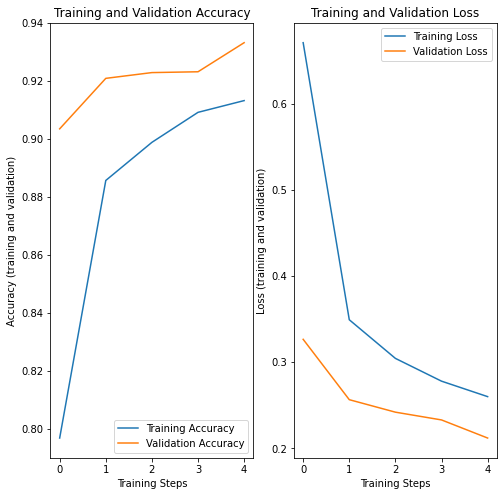

In [29]:
import matplotlib.pylab as plt
import numpy as np

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(EPOCHS)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')
plt.ylabel("Accuracy (training and validation)")
plt.xlabel("Training Steps")

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.ylabel("Loss (training and validation)")
plt.xlabel("Training Steps")
plt.show()

### Random test
Random sample images from validation dataset and predict

In [30]:
# Import OpenCV
import cv2

# Utility
import itertools
import random
from collections import Counter
from glob import iglob


def load_image(filename):
    img = cv2.imread(os.path.join(data_dir, validation_dir, filename))
    img = cv2.resize(img, (IMAGE_SIZE[0], IMAGE_SIZE[1]) )
    img = img /255
    
    return img


def predict(image):
    probabilities = model.predict(np.asarray([img]))[0]
    class_idx = np.argmax(probabilities)
    
    return {classes[class_idx]: probabilities[class_idx]}

SOURCE: class: Soybean___healthy, file: Soybean___healthy\3a0f4849-4edd-4f88-b80e-a2cd69b91295___RS_HL 3568_final_masked.jpg


C:\Users\Chavan\anaconda3\lib\site-packages\tensorflow\python\keras\engine\training.py:2325: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


PREDICTED: class: Soybean___healthy, confidence: 0.972803


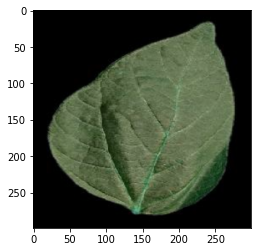

<Figure size 432x288 with 0 Axes>

SOURCE: class: Tomato___Tomato_Yellow_Leaf_Curl_Virus, file: Tomato___Tomato_Yellow_Leaf_Curl_Virus\6cb06d49-6091-4757-a314-abd1db0c6dbd___YLCV_NREC 0249.JPG
PREDICTED: class: Tomato___Tomato_Yellow_Leaf_Curl_Virus, confidence: 0.999992


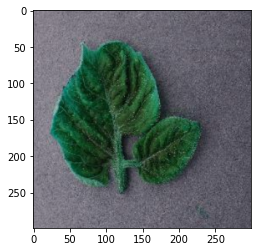

SOURCE: class: Apple___healthy, file: Apple___healthy\af2972a9-c62d-44bf-a5df-45c0bdf70572___RS_HL 5835_final_masked.jpg
PREDICTED: class: Apple___healthy, confidence: 0.979375


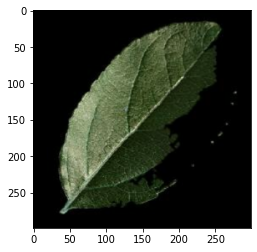

<Figure size 432x288 with 0 Axes>

SOURCE: class: Peach___Bacterial_spot, file: Peach___Bacterial_spot\4b73b4be-536b-4b9c-b932-a89edcc278dc___Rutg._Bact.S 1323_final_masked.jpg
PREDICTED: class: Peach___Bacterial_spot, confidence: 0.999409


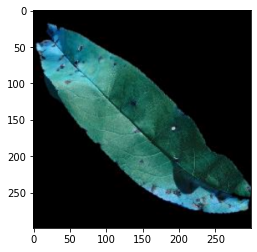

<Figure size 432x288 with 0 Axes>

SOURCE: class: Tomato___Spider_mites Two-spotted_spider_mite, file: Tomato___Spider_mites Two-spotted_spider_mite\15bb3ac6-73b8-4e56-b70b-1bf53fdc6dba___Com.G_SpM_FL 1568.JPG
PREDICTED: class: Tomato___Spider_mites Two-spotted_spider_mite, confidence: 0.632673


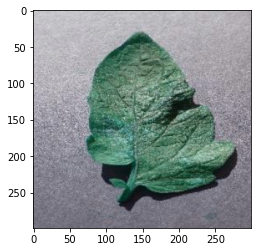

<Figure size 432x288 with 0 Axes>

In [31]:
for idx, filename in enumerate(random.sample(validation_generator.filenames, 5)):
    print("SOURCE: class: %s, file: %s" % (os.path.split(filename)[0], filename))
    
    img = load_image(filename)
    prediction = predict(img)
    print("PREDICTED: class: %s, confidence: %f" % (list(prediction.keys())[0], list(prediction.values())[0]))
    plt.imshow(img)
    plt.figure(idx)    
    plt.show()

## Export as saved model and convert   to TFLite
Now that you've trained the model, export it as a saved model

In [ ]:
from keras.models import load_model
model.save('crop_new.h5')

In [35]:
from keras.models import load_model
model.save_weights('crop_new_weights.h5')

In [99]:
import keras
t = time.time()

#export_path = "/tmp/saved_models/{}".format(int(t))
#tf.keras.experimental.export_saved_model(model, export_path)

#export_path
path = "./crop_new.h5"# or you can simply use 'my_mode.h5'
#model.save(saved_model_path) #save your model 

# to reload your model 
#model = keras.models.load_model(saved_model_path)

reloaded = tf.keras.models.load_model((path),custom_objects={'KerasLayer':hub.KerasLayer})

In [100]:
def predict_reload(image):
    probabilities = reloaded.predict(np.asarray([img]))[0]
    class_idx = np.argmax(probabilities)
    
    return {classes[class_idx]: probabilities[class_idx]}

SOURCE: class: Pepper,_bell___healthy, file: Pepper,_bell___healthy\dbb6495b-0765-4d94-afad-6020819aa893___JR_HL 8233_final_masked.jpg
PREDICTED: class: Pepper,_bell___healthy, confidence: 0.954335


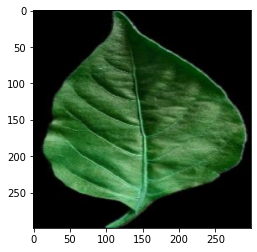

<Figure size 432x288 with 0 Axes>

SOURCE: class: Soybean___healthy, file: Soybean___healthy\1ce3d571-ac13-480d-be65-a12fe956c6e6___RS_HL 3904_final_masked.jpg
PREDICTED: class: Soybean___healthy, confidence: 0.997153


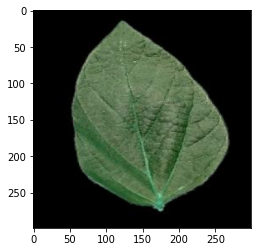

In [101]:
for idx, filename in enumerate(random.sample(validation_generator.filenames, 2)):
    print("SOURCE: class: %s, file: %s" % (os.path.split(filename)[0], filename))
    
    img = load_image(filename)
    prediction = predict_reload(img)
    print("PREDICTED: class: %s, confidence: %f" % (list(prediction.keys())[0], list(prediction.values())[0]))
    plt.imshow(img)
    plt.figure(idx)    
    plt.show()

In [ ]:
from tensorflow.contrib import lite
converter = lite.TFLiteConverter.from_keras_model_file( 'crop_new.h5')
tfmodel = converter.convert()
open ("new_model.tflite" , "wb") .write(tfmodel)

In [1]:
 pip install tensorflow_estimator

Note: you may need to restart the kernel to use updated packages.
